In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [6]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# Download
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gleni\.cache\kagglehub\datasets\aslanahmedov\walmart-sales-forecast\versions\1


In [7]:
df_train = pd.read_csv(path + "/train.csv")
df_test = pd.read_csv(path + "/test.csv")
df_stores = pd.read_csv(path + "/stores.csv")
df_features = pd.read_csv(path + "/features.csv")

In [8]:
df = df_train.merge(df_features, on=["Store", "Date"], how="inner").merge(df_stores, on=["Store"], how="inner")
df_test = df_test.merge(df_features, on=["Store", "Date"], how="inner").merge(df_stores, on=["Store"], how="inner")

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [10]:
df['Week'] = df['Date'].dt.isocalendar().week
df_test['Week'] = df_test['Date'].dt.isocalendar().week

df['Day_of_week'] =df['Date'].dt.dayofweek
df_test['Day_of_week'] =df_test['Date'].dt.dayofweek

df['Month'] =df['Date'].dt.month 
df_test['Month'] =df_test['Date'].dt.month 

df['Year'] =df['Date'].dt.year
df_test['Year'] =df_test['Date'].dt.year

df['Day'] =df['Date'].dt.day 
df_test['Day'] =df_test['Date'].dt.day

In [11]:
train = df.drop(columns=['IsHoliday_x'])
test = df_test.drop(columns=['IsHoliday_x'])

In [12]:
train['IsHoliday_y'] = train['IsHoliday_y'].astype(int)
test['IsHoliday_y'] = test['IsHoliday_y'].astype(int)

In [13]:
train.drop(columns=['MarkDown4', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature'], inplace=True)

In [14]:
train['Type'] = train['Type'].map({'A': 1, 'B': 2, 'C': 3})
test['Type'] = test['Type'].map({'A': 1, 'B': 2, 'C': 3})

In [15]:
train.fillna(0, inplace=True)
#test.isnull().sum()

In [16]:
train['sample_weight'] = train['IsHoliday_y'].apply(lambda x: 5 if x == 1 else 1)

In [17]:
cutoff_date = '2011-12-31'
cutoff_date_val = '2012-06-30'

In [18]:
train_data = train[train['Date'] <= cutoff_date]
val_data = train[(train['Date'] > cutoff_date) & (train['Date'] <= cutoff_date_val)]
test_data = train[train['Date'] > cutoff_date_val]

In [19]:
# --- Training set
train_x = train_data.drop(columns=['Weekly_Sales', 'Date'])
train_y = train_data['Weekly_Sales'].values
train_weights = train_data['sample_weight'].values

# --- Validation set
val_x = val_data.drop(columns=['Weekly_Sales', 'Date'])
val_y = val_data['Weekly_Sales'].values
val_weights = val_data['sample_weight'].values

# --- Test set
test_x = test_data.drop(columns=['Weekly_Sales', 'Date'])
test_y = test_data['Weekly_Sales'].values
test_weights = test_data['sample_weight'].values

In [20]:
print(train_x.shape, train_y.shape, train_weights.shape)
print(val_x.shape, val_y.shape, val_weights.shape)
print(test_x.shape, test_y.shape, test_weights.shape)

(294132, 15) (294132,) (294132,)
(77110, 15) (77110,) (77110,)
(50328, 15) (50328,) (50328,)


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
val_x_scaled = scaler.transform(val_x)
test_x_scaled = scaler.transform(test_x)

In [22]:
def create_sequences(x, y, weights, time_steps=5):
    X_seq, y_seq, w_seq = [], [], []
    for i in range(time_steps, len(x)):
        X_seq.append(x[i - time_steps:i])
        y_seq.append(y[i])
        w_seq.append(weights[i])  # weight for target time step
    return np.array(X_seq), np.array(y_seq), np.array(w_seq)

time_steps = 10
train_X, train_y, train_w = create_sequences(train_x_scaled, train_y, train_weights, time_steps)
val_X, val_y, val_w = create_sequences(val_x_scaled, val_y, val_weights, time_steps)

In [23]:
print(train_X.shape, train_y.shape, train_w.shape)
print(test_x_scaled.shape, test_y.shape, test_weights.shape)
print(val_X.shape, val_y.shape, val_w.shape)

(294122, 10, 15) (294122,) (294122,)
(50328, 15) (50328,) (50328,)
(77100, 10, 15) (77100,) (77100,)


In [24]:
from tensorflow.keras.losses import MeanAbsoluteError
loss_fn = MeanAbsoluteError()

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


model = Sequential([
    LSTM(64, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Regression
])

In [26]:
class R2ScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred_train = self.model.predict(train_X, verbose=0).flatten()
        y_pred_val = self.model.predict(val_X, verbose=0).flatten()
        r2_train = r2_score(train_y, y_pred_train)
        r2_val = r2_score(val_y, y_pred_val)
        print(f"\nEpoch {epoch + 1}: R² Train = {r2_train:.4f}, R² Val = {r2_val:.4f}")


r2_callback = R2ScoreCallback()

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [28]:
history = model.fit(
    train_X, train_y,
    sample_weight=train_w,
    validation_data=(val_X, val_y, val_w),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, R2ScoreCallback()],
    verbose=1
)

Epoch 1/30
4585/4596 [============================>.] - ETA: 0s - loss: 890187520.0000 - mae: 14482.4463WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: R² Train = 0.0290, R² Val = 0.0373
4596/4596 [==============================] - 76s 13ms/step - loss: 889469696.0000 - mae: 14481.3359 - val_loss: 564606528.0000 - val_mae: 14259.6836
Epoch 2/30
4587/4596 [============================>.] - ETA: 0s - loss: 687249664.0000 - mae: 13102.5537WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 2: R² Train = 0

In [29]:
test_x_scaled = scaler.transform(test_x)

# Create sequences from test data
test_X, test_y, test_w = create_sequences(test_x_scaled, test_y, test_weights, time_steps)

# Check shapes (optional)
print(test_X.shape, test_y.shape, test_w.shape)

(50318, 10, 15) (50318,) (50318,)


In [30]:
# Predict with the trained model
pred_y = model.predict(test_X, verbose=0).flatten()

In [31]:
mae = mean_absolute_error(test_y, pred_y)
rmse = np.sqrt(mean_squared_error(test_y, pred_y))
r2 = r2_score(test_y, pred_y)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.4f}")

Test MAE: 10921.37
Test RMSE: 16718.70
Test R² Score: 0.4209


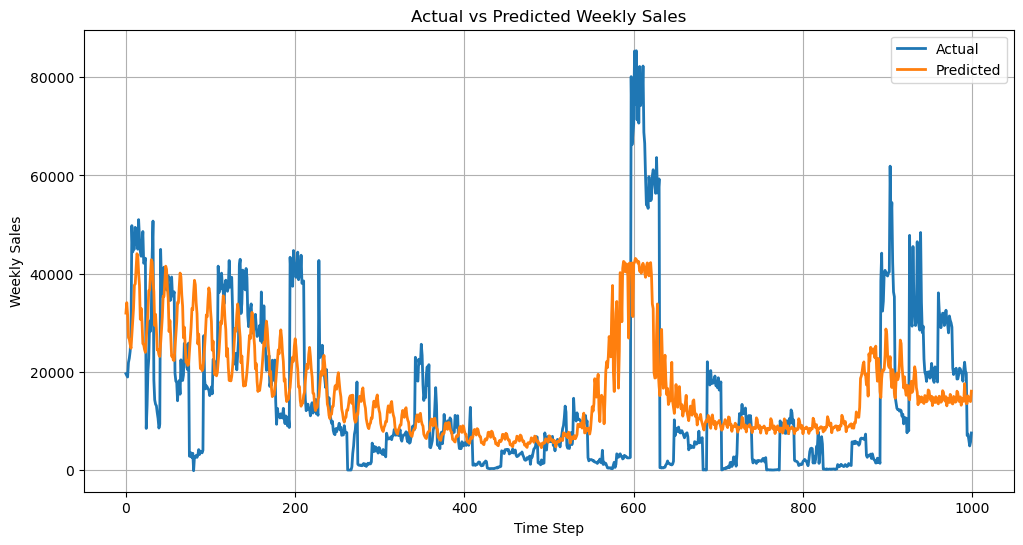

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_y[:1000], label='Actual', linewidth=2)
plt.plot(pred_y[:1000], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Time Step')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid()
plt.show()